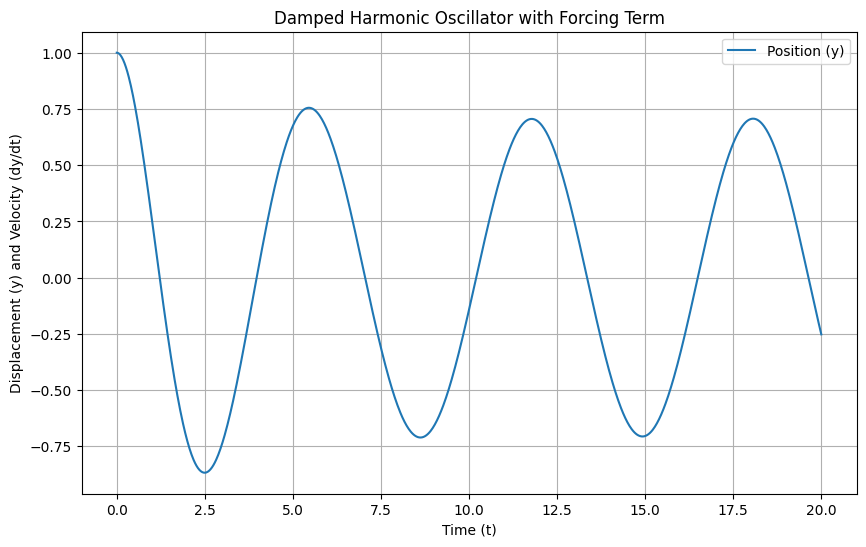

In [243]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters
m = 1.0        # Mass (kg)
gamma = 0.1    # Damping coefficient (kg/s)
k = 1.0        # Spring constant (N/m)
F0 = 1.0       # Forcing amplitude (N)
omega = 1.0    # Forcing frequency (rad/s)
y0 = 1.0       # Initial position (m)
v0 = 0       # Initial velocity (m/s)

def F(t):
    return np.sin(t)

# System of first-order ODEs
def harmonic_oscillator(t, y):
    x1, x2 = y
    dx1dt = x2
    dx2dt = - x2 - 2*x1 - F(t)
    return [dx1dt, dx2dt]

# Time span for the simulation
t_span = (0, 20)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Initial conditions (initial position and velocity)
y_init = [y0, v0]

# Solve the ODE
sol = solve_ivp(harmonic_oscillator, t_span, y_init, t_eval=t_eval)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label="Position (y)")
# plt.plot(sol.t, sol.y[1], label="Velocity (dy/dt)", linestyle='--')
plt.title("Damped Harmonic Oscillator with Forcing Term")
plt.xlabel("Time (t)")
plt.ylabel("Displacement (y) and Velocity (dy/dt)")
plt.legend()
plt.grid(True)
plt.show()


In [244]:
import torch
# Add the parent directory of the script (i.e., project/) to sys.path
import sys
sys.path.append('../../utils')
from upinn import UPINN
from architectures import FNN, ResNet
from utils import SINDy_sklearn, sample_collocation_points

In [245]:
td = torch.tensor(sol.t[29::30], dtype=torch.float32).reshape(-1, 1)
yd = torch.tensor(sol.y[0][29::30], dtype=torch.float32).reshape(-1, 1)

In [246]:
tbc = torch.tensor([[0.0]], dtype=torch.float32)
ybc = torch.tensor([[y0]], dtype=torch.float32)

In [247]:
tc = sample_collocation_points(1000, 1, [0], [20], method='grid')

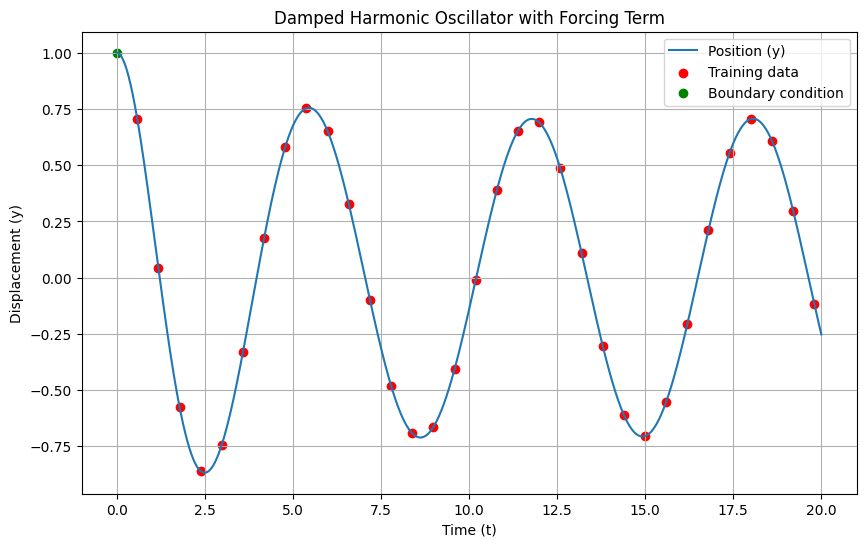

In [248]:
# Plot the training data
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label="Position (y)")
plt.scatter(td, yd, color='red', label="Training data")
plt.scatter(tbc.detach(), ybc, color='green', label="Boundary condition")
# plt.scatter(tc.detach(), torch.zeros_like(tc.detach()), color='orange', label="Collocation points")
plt.title("Damped Harmonic Oscillator with Forcing Term")
plt.xlabel("Time (t)")
plt.ylabel("Displacement (y)")
plt.legend()
plt.grid(True)
plt.show()

In [249]:
class HarmonicOscillator(torch.nn.Module):
    def __init__(self):
        super(HarmonicOscillator, self).__init__()
    
    def forward(self, t, x):

        dxdt = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
        d2xdt2 = torch.autograd.grad(dxdt, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]

        return d2xdt2 + dxdt + 10 * x

N = HarmonicOscillator()

In [250]:
class HarmonicOscillatorUPINN(UPINN):
    
    def F_input(self, t, x):
        return t
    

    def bc_loss(self):

        if self.boundary_points is not None:
            U_bc = self.u(self.boundary_points[0])
            bc_loss = torch.mean((U_bc - self.boundary_points[1])**2)

            dUdt_bc = torch.autograd.grad(U_bc, self.boundary_points[0], grad_outputs=torch.ones_like(U_bc), create_graph=True)[0]

            bc_loss += torch.mean((dUdt_bc-v0)**2)

            return bc_loss
        else:
            return torch.tensor(0.0)

In [251]:
hidden1 = [16]*4
u = FNN([1, *hidden1, 1])
hidden2 = [16]*2
F = FNN([1, *hidden2, 1])
model = HarmonicOscillatorUPINN(u, N, F, data_points=(td, yd), boundary_points=(tbc, ybc), collocation_points=tc)
# model = HarmonicOscillatorUPINN(u, N, F, data_points=(td, yd), boundary_points=(tbc, ybc))
model.boundary_points[0].requires_grad = True

[Info]: Initializing UPINN model


In [252]:
adam = torch.optim.AdamW(model.parameters(), lr=1e-3)
model.optimizer = adam

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(adam, factor=0.9, patience=1000)
model.scheduler = scheduler

# lbfgs = torch.optim.LBFGS(model.parameters(), lr=1e-1)
# model.optimizer = lbfgs

[Info]: Training 10000 epoch(s) on cpu using AdamW optimizer.


[CPU]: 100%|██████████| 10000/10000 [02:01<00:00, 82.41 epoch/s, bc_loss=1.33e-06, data_loss=5.36e-02, pde_loss=7.09e-04, loss=5.43e-02]


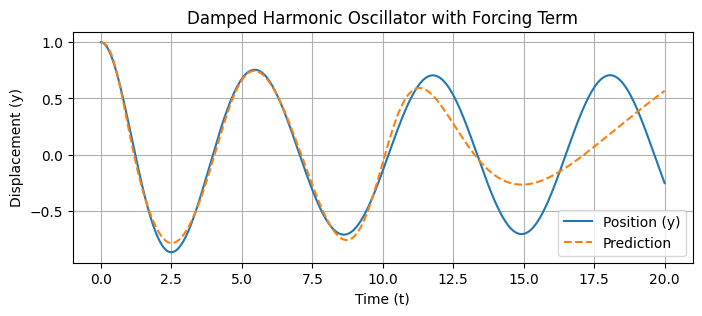

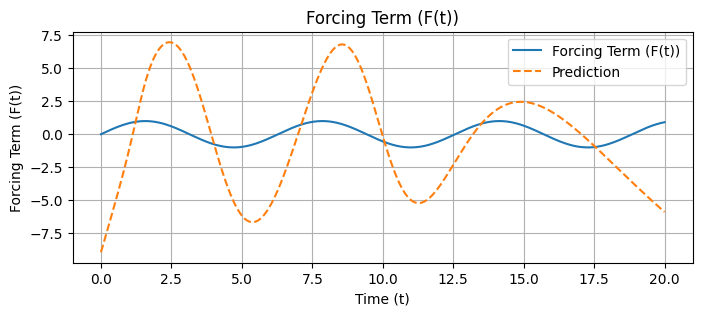

[Info]: Training 10000 epoch(s) on cpu using AdamW optimizer.


[CPU]: 100%|██████████| 10000/10000 [01:58<00:00, 84.69 epoch/s, bc_loss=1.37e-06, data_loss=5.35e-02, pde_loss=7.13e-04, loss=5.42e-02]


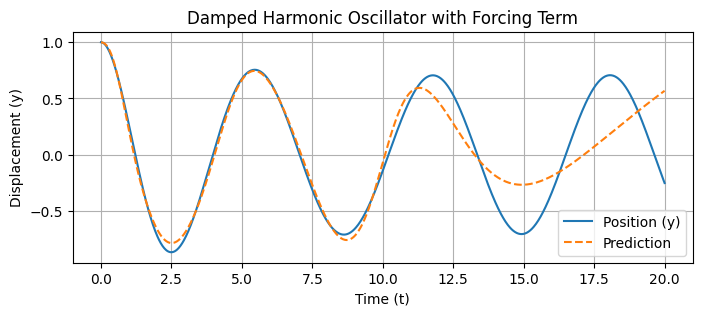

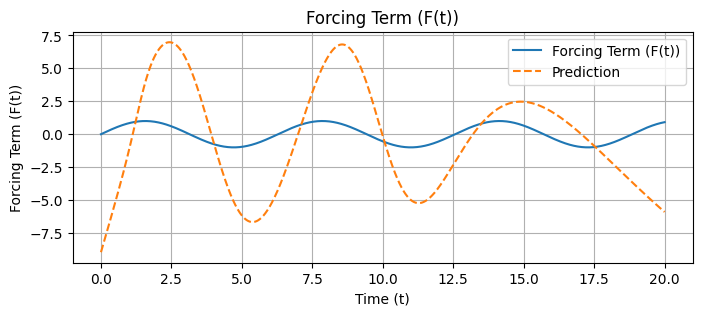

[Info]: Training 10000 epoch(s) on cpu using AdamW optimizer.


[CPU]: 100%|██████████| 10000/10000 [02:01<00:00, 82.35 epoch/s, bc_loss=1.24e-06, data_loss=5.34e-02, pde_loss=7.18e-04, loss=5.41e-02]


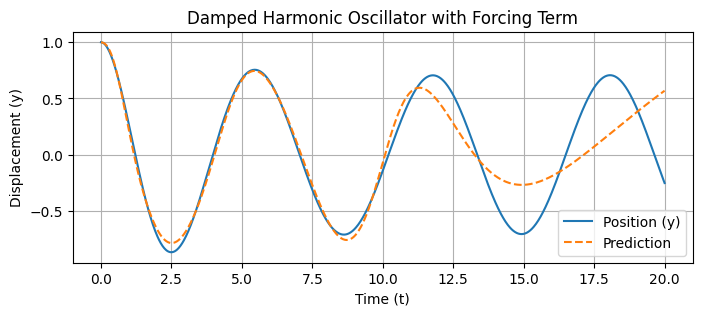

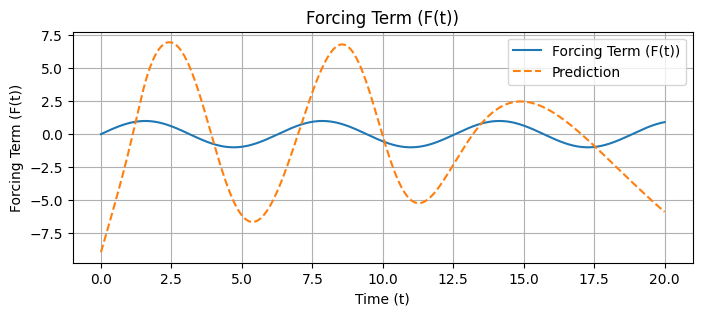

[Info]: Training 10000 epoch(s) on cpu using AdamW optimizer.


[CPU]: 100%|██████████| 10000/10000 [01:53<00:00, 87.97 epoch/s, bc_loss=1.17e-06, data_loss=5.33e-02, pde_loss=7.48e-04, loss=5.41e-02]


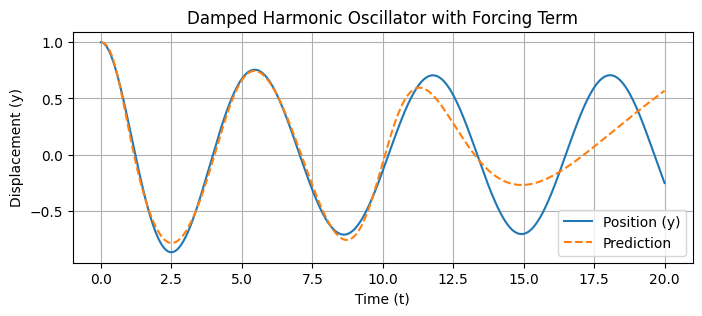

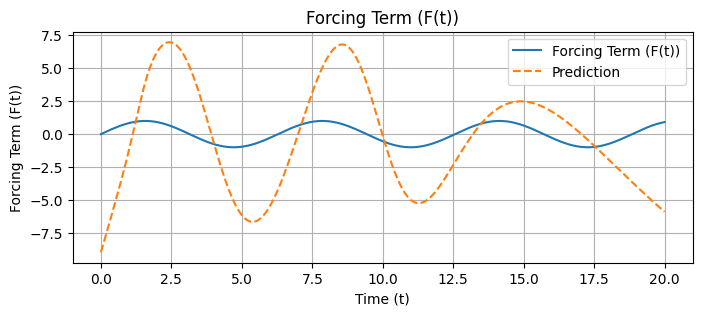

[Info]: Training 10000 epoch(s) on cpu using AdamW optimizer.


[CPU]: 100%|██████████| 10000/10000 [02:00<00:00, 83.32 epoch/s, bc_loss=1.36e-06, data_loss=5.32e-02, pde_loss=7.29e-04, loss=5.40e-02]


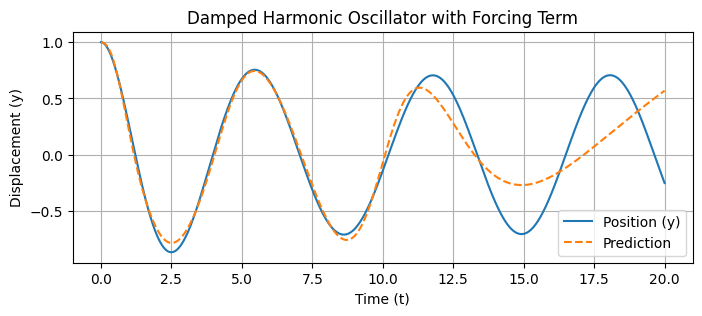

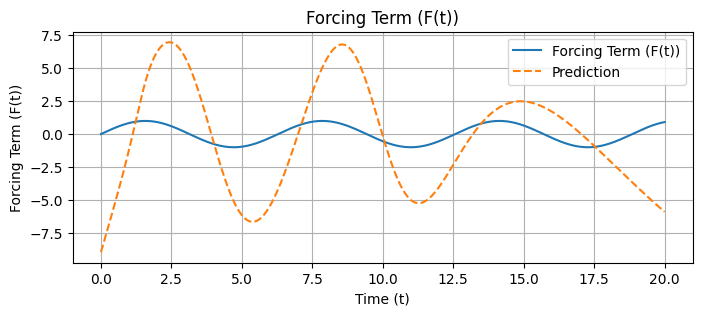

[Info]: Training 10000 epoch(s) on cpu using AdamW optimizer.


[CPU]: 100%|██████████| 10000/10000 [01:55<00:00, 86.66 epoch/s, bc_loss=1.07e-06, data_loss=5.31e-02, pde_loss=7.41e-04, loss=5.39e-02]


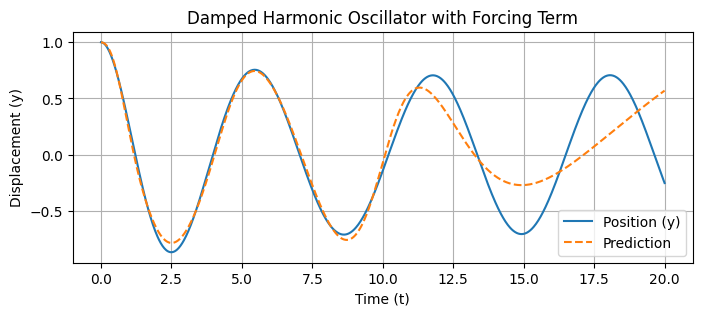

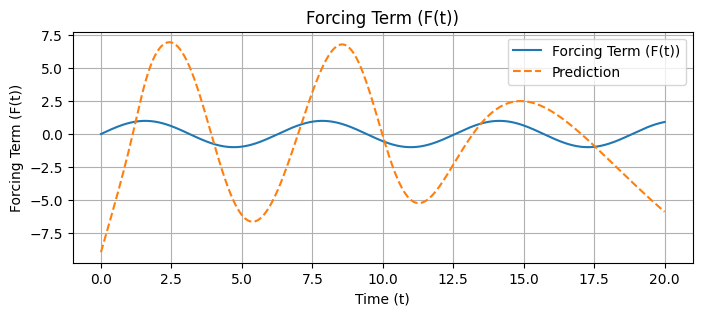

[Info]: Training 10000 epoch(s) on cpu using AdamW optimizer.


[CPU]: 100%|██████████| 10000/10000 [01:56<00:00, 86.18 epoch/s, bc_loss=1.17e-06, data_loss=5.30e-02, pde_loss=7.47e-04, loss=5.37e-02]


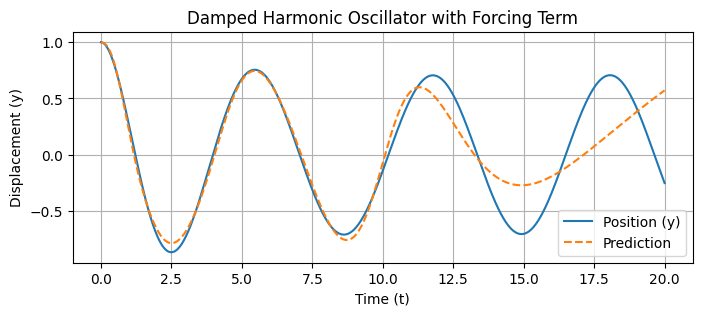

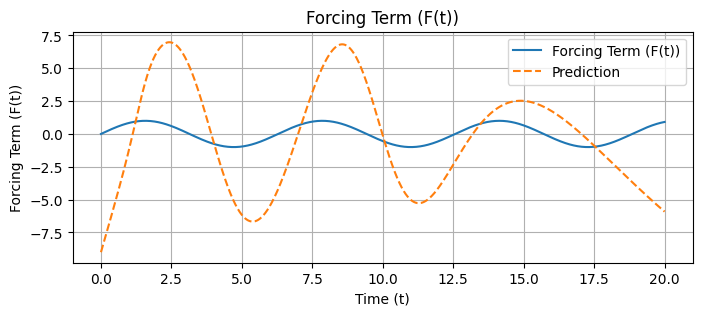

[Info]: Training 10000 epoch(s) on cpu using AdamW optimizer.


[CPU]: 100%|██████████| 10000/10000 [01:59<00:00, 83.73 epoch/s, bc_loss=1.25e-06, data_loss=5.28e-02, pde_loss=7.48e-04, loss=5.36e-02]


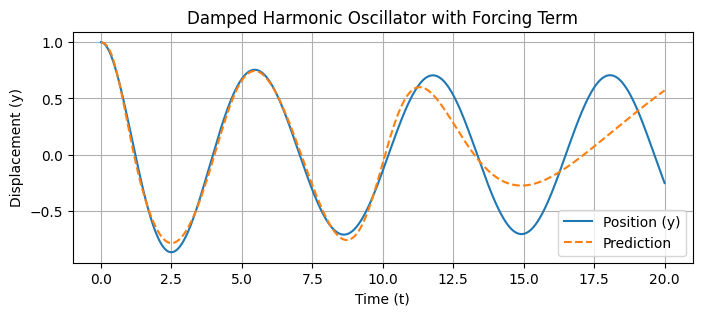

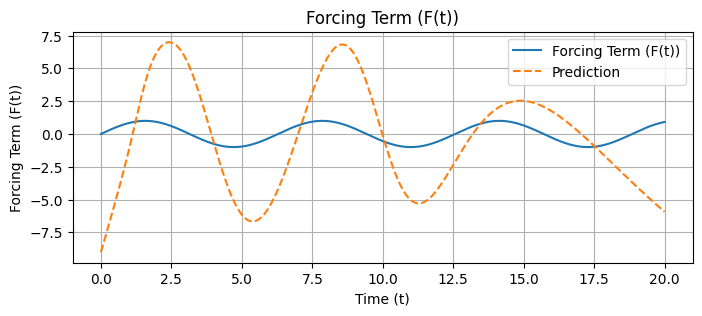

[Info]: Training 10000 epoch(s) on cpu using AdamW optimizer.


[CPU]:  92%|█████████▏| 9161/10000 [01:53<00:10, 80.87 epoch/s, bc_loss=1.13e-06, data_loss=5.27e-02, pde_loss=7.49e-04, loss=5.34e-02]


KeyboardInterrupt: 

In [259]:
for i in range(20):
    model.train_loop(10000, device='cpu')
    # Plot results
    t = torch.linspace(0, 20, 1000).reshape(-1, 1)
    y = model.predict(t)

    plt.figure(figsize=(8, 3))
    plt.plot(sol.t, sol.y[0], label="Position (y)")
    plt.plot(t.detach().numpy(), y.detach().numpy(), label="Prediction", linestyle='--')
    plt.title("Damped Harmonic Oscillator with Forcing Term")
    plt.xlabel("Time (t)")
    plt.ylabel("Displacement (y)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the forcing term
    def F(t):
        return np.sin(t)

    f = F(t)

    # Get prediction
    f_pred = model.F(model.F_input(t, y))

    plt.figure(figsize=(8, 3))
    plt.plot(t.detach().numpy(), f.detach().numpy(), label="Forcing Term (F(t))")
    plt.plot(t.detach().numpy(), f_pred.detach().numpy(), label="Prediction", linestyle='--')
    plt.title("Forcing Term (F(t))")
    plt.xlabel("Time (t)")
    plt.ylabel("Forcing Term (F(t))")
    plt.legend()
    plt.grid(True)
    plt.show()


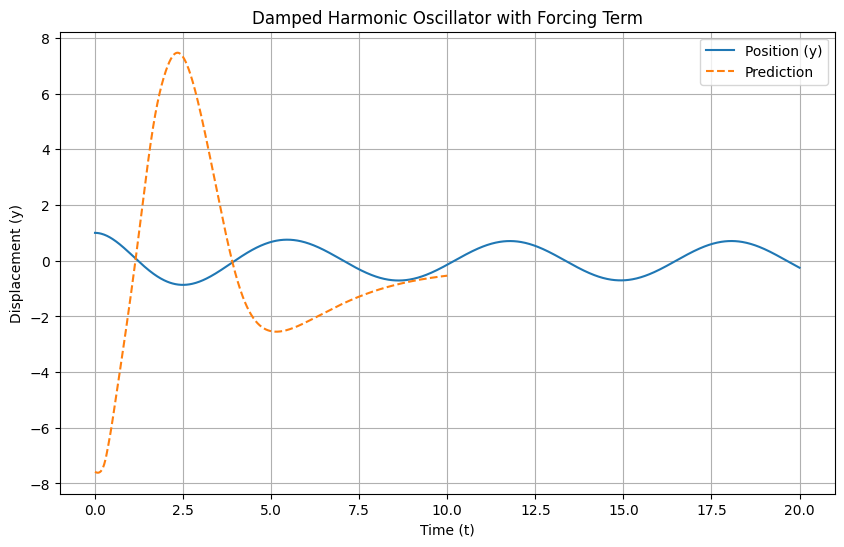

In [254]:
# Plot results
t = torch.linspace(0, 10, 1000).reshape(-1, 1)
y = model.predict(t)
F = model.F(model.F_input(t, y))

plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label="Position (y)")
plt.plot(t.detach().numpy(), F.detach().numpy(), label="Prediction", linestyle='--')
plt.title("Damped Harmonic Oscillator with Forcing Term")
plt.xlabel("Time (t)")
plt.ylabel("Displacement (y)")
plt.legend()
plt.grid(True)
plt.show()


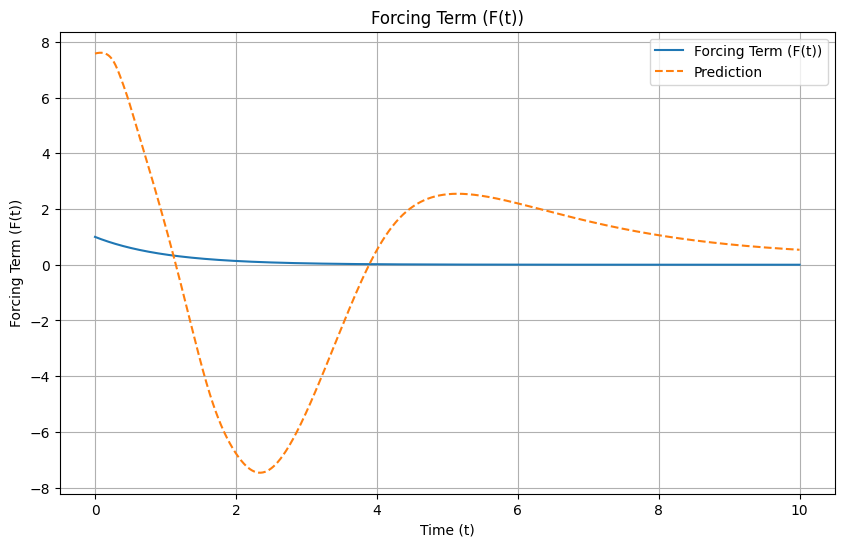

In [255]:
# Plot the forcing term
def F(t):
    return np.exp(-t)

t = torch.linspace(0, 10, 1000).reshape(-1, 1)
f = F(t)

# Get prediction
f_pred = -model.F(model.F_input(t, y))

plt.figure(figsize=(10, 6))
plt.plot(t.detach().numpy(), f.detach().numpy(), label="Forcing Term (F(t))")
plt.plot(t.detach().numpy(), f_pred.detach().numpy(), label="Prediction", linestyle='--')
plt.title("Forcing Term (F(t))")
plt.xlabel("Time (t)")
plt.ylabel("Forcing Term (F(t))")
plt.legend()
plt.grid(True)
plt.show()
